*GoogleDrive Mounting*

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Data Fetching*

---



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa

base_dir = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/Final Project/Dataset'

honks_dir = os.path.join(base_dir, 'Honks')
non_honks_dir = os.path.join(base_dir, 'Non-Honks')

print(len(honks_dir))
print(len(non_honks_dir))

86
90


*Feature Extraction*

---



In [3]:
dfs = []
genres = {'Honks': 0, 'Non-Honks': 1}

# Iterate over each genre and file to populate the DataFrame
for genre, genre_number in genres.items():
    directory = os.path.join(base_dir, genre)
    genre_data = []
    for filename in os.listdir(directory):
        files = os.path.join(directory, filename)
        y, sr = librosa.load(files, mono=True, duration=2)
        ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_fft=512, n_mels=64)
        ps = librosa.power_to_db(ps**2)
        genre_data.append({'spectrogram': ps, 'type': genre_number})
    genre_df = pd.DataFrame(genre_data)
    dfs.append(genre_df)

# Concatenate the DataFrames
df = pd.concat(dfs, ignore_index=True)

print(df.shape)
print(df.head())

(1080, 2)
                                         spectrogram  type
0  [[-35.326603, -30.978722, -27.9755, -36.716133...     0
1  [[-33.3636, -23.577671, -26.346287, -25.401001...     0
2  [[-100.00001, -100.00001, -100.00001, -100.000...     0
3  [[-100.00001, -100.00001, -100.00001, -100.000...     0
4  [[-100.00001, -100.00001, -100.00001, -100.000...     0


*Spectrogram Visualization*

---



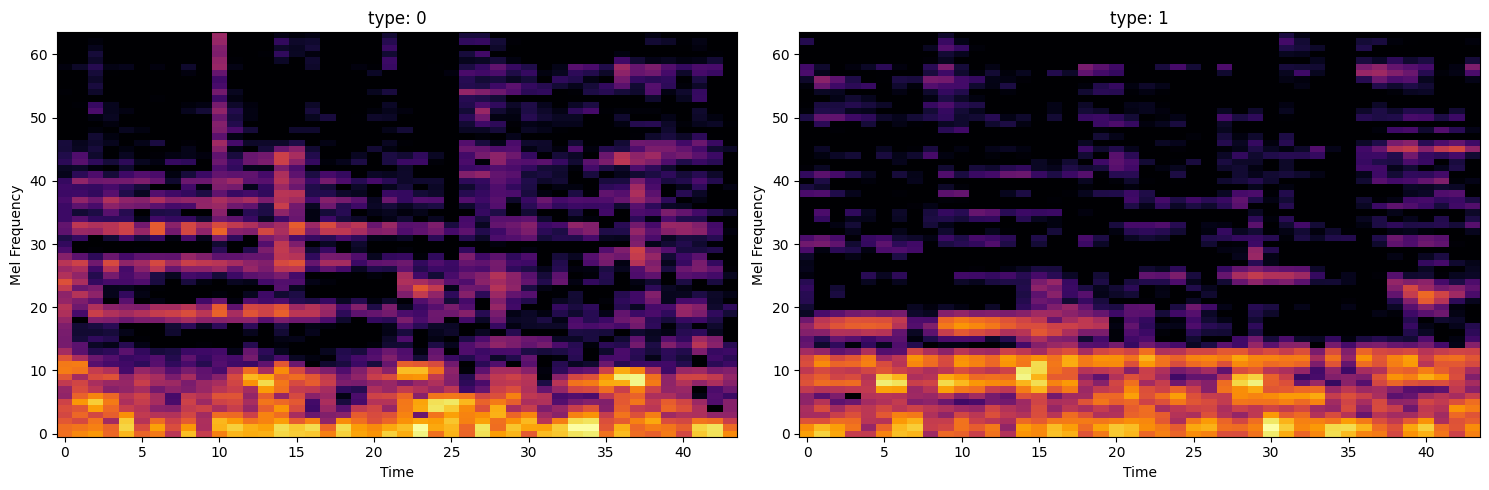

In [4]:
# Create a figure and axis for subplots
fig, axs = plt.subplots(1, len(df['type'].unique()), figsize=(15, 5))

# Visualize one sample from each type
for i, type_number in enumerate(df['type'].unique()):
    type_df = df[df['type'] == type_number]
    sample_ps_data = type_df.iloc[0]['spectrogram']  # Take the first sample for each type
    ax = axs[i]
    ax.imshow(sample_ps_data, aspect='auto', origin='lower', cmap='inferno')
    ax.set_title(f'type: {type_number}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Frequency')
    # ax.colorbar(label='Power (dB)')

plt.tight_layout()
plt.show()


In [5]:
a = df['spectrogram'].iloc[1]
a.shape

(64, 44)

In [17]:
shuffled_df = df.sample(frac = 1, random_state = 42)
shuffled_df

,spectrogram,type
423,"[[-37.457146, -46.962036, -49.97829, -49.54526...",0
548,"[[-100.00001, -100.00001, -100.00001, -100.000...",1
731,"[[-42.0982, -48.023605, -52.21613, -66.324066,...",1
588,"[[-77.92032, -60.494503, -56.061115, -56.69740...",1
1051,"[[0.30176544, -9.418348, -8.753028, -3.5559037...",1
...,...,...
330,"[[-2.2331886, -5.0698166, 2.282483, -3.5732543...",0
466,"[[-52.36026, -33.060246, -28.859333, -43.99897...",0
121,"[[-63.05634, -30.936886, -37.366913, -41.37052...",0
1044,"[[-8.075461, -3.1011071, -17.020971, -5.560870...",1


*Train Test Split*

---



In [18]:
from sklearn.model_selection import train_test_split

# perform three-way split to train, val, test
x = shuffled_df['spectrogram']
y = shuffled_df['type']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.1, random_state = 123)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.4, random_state = 123)

x_train = np.array([np.expand_dims(x, axis=-1) for x in x_train])
x_val = np.array([np.expand_dims(x, axis=-1) for x in x_val])
x_test = np.array([np.expand_dims(x, axis=-1) for x in x_test])

# Repeat the single channel to create three channels
x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

print(f'train data: {x_train.shape}, train label: {y_train.shape}')
print(f'val data {x_val.shape}, val label: {y_val.shape}')
print(f'test data {x_test.shape}, test label {y_test.shape}')

print(x_train[0].shape)
print(x_val[0].shape)
print(x_test[0].shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

train data: (972, 64, 44, 3), train label: (972,)
val data (64, 64, 44, 3), val label: (64,)
test data (44, 64, 44, 3), test label (44,)
(64, 44, 3)
(64, 44, 3)
(64, 44, 3)
(972,)
(64,)
(44,)


In [19]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train.shape, y_val.shape, y_test.shape)

(972, 2) (64, 2) (44, 2)


*Model Development*

---



In [21]:
from tensorflow.keras.applications import ResNet50

# load ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 44, 3), pooling='max')

for layer in base_model.layers:
    layer.trainable = False


In [22]:
# model's architecture
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24646018 (94.02 MB)
Trainable params: 1054210 (4.02 MB)
Non-trainable params: 23591808 (90.00 MB)
________

In [23]:
from tensorflow.keras.applications import VGG16

# load VGG16 Model
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 44, 3), pooling='max')

for layer in VGG16_base_model.layers:
    layer.trainable = False

In [24]:
vgg_model = Sequential([
    VGG16_base_model,
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(2, activation='softmax')
])

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14980418 (57.15 MB)
Trainable params: 264706 (1.01 MB)
Non-trainable params: 14715712 (56.14 MB)
_________

In [77]:
# compiling the model
model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

vgg_model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

*Model Training*

---



In [78]:
vgg_hist = vgg_model.fit(
      x_train, y_train,
      epochs = 15,
      validation_data = (x_val, y_val),
      batch_size = 64,
      # validation_steps= 27,
      verbose = 1,
      # callbacks = [callbacks]
)

Epoch 1/15
16/16 [==============================] - 2s 44ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 1.0306 - val_accuracy: 0.8906
Epoch 2/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0071 - accuracy: 0.9959 - val_loss: 1.0567 - val_accuracy: 0.8906
Epoch 3/15
16/16 [==============================] - 0s 22ms/step - loss: 0.0068 - accuracy: 0.9969 - val_loss: 0.9237 - val_accuracy: 0.8750
Epoch 4/15
16/16 [==============================] - 0s 26ms/step - loss: 0.0222 - accuracy: 0.9949 - val_loss: 0.8520 - val_accuracy: 0.8750
Epoch 5/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0150 - accuracy: 0.9928 - val_loss: 0.7415 - val_accuracy: 0.8906
Epoch 6/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0137 - accuracy: 0.9979 - val_loss: 0.8108 - val_accuracy: 0.8906
Epoch 7/15
16/16 [==============================] - 0s 22ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.7075 - val_accuracy: 0.9062
Epoch 8/15
16

In [79]:
model_hist = model.fit(
      x_train, y_train,
      epochs = 15,
      validation_data = (x_val, y_val),
      batch_size = 64,
      # validation_steps= 27,
      verbose = 1,
      # callbacks = [callbacks]
)

Epoch 1/15
16/16 [==============================] - 5s 100ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 1.3985 - val_accuracy: 0.8438
Epoch 2/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.4520 - val_accuracy: 0.8594
Epoch 3/15
16/16 [==============================] - 0s 23ms/step - loss: 9.1886e-05 - accuracy: 1.0000 - val_loss: 1.4325 - val_accuracy: 0.8906
Epoch 4/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 1.2486 - val_accuracy: 0.8594
Epoch 5/15
16/16 [==============================] - 0s 23ms/step - loss: 2.6519e-04 - accuracy: 1.0000 - val_loss: 1.2296 - val_accuracy: 0.8594
Epoch 6/15
16/16 [==============================] - 0s 23ms/step - loss: 8.0579e-04 - accuracy: 0.9990 - val_loss: 1.3534 - val_accuracy: 0.8594
Epoch 7/15
16/16 [==============================] - 0s 23ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 1.2647 - val_accuracy: 0.8750


*Model Training History*

---



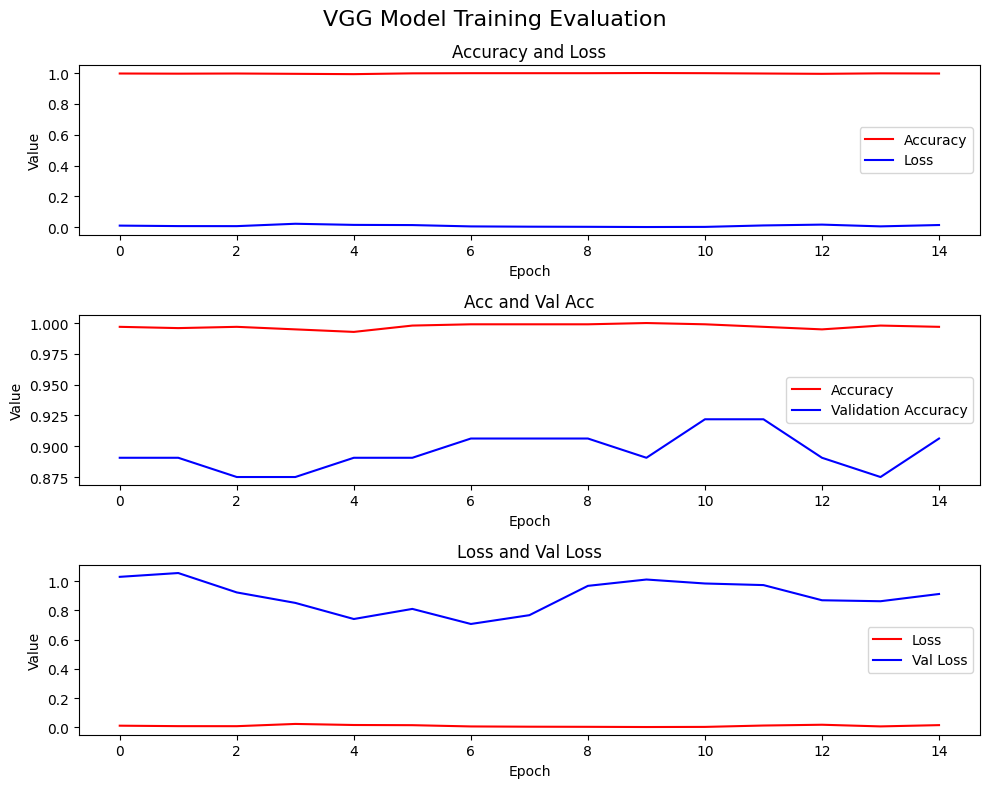

In [80]:
accuracy = vgg_hist.history['accuracy']
validation_accuracy = vgg_hist.history['val_accuracy']
loss = vgg_hist.history['loss']
validation_loss = vgg_hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (10, 8))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

fig.suptitle('VGG Model Training Evaluation', fontsize=16)

plt.tight_layout()
plt.show()

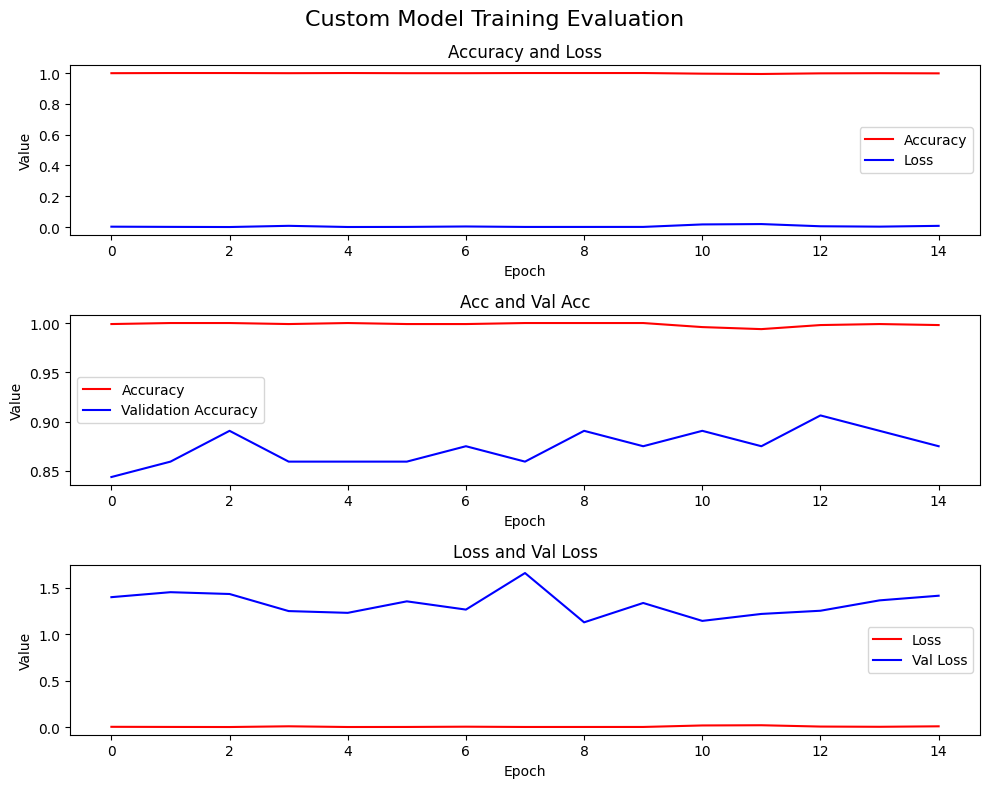

In [81]:
accuracy = model_hist.history['accuracy']
validation_accuracy = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
validation_loss = model_hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (10, 8))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

fig.suptitle('Custom Model Training Evaluation', fontsize=16)

plt.tight_layout()
plt.show()

*Model Testing*

---



In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = pd.DataFrame(
    columns = ['model', 'VGG'],
    index = ['acc', 'prec', 'rec', 'f1']
)

def test(classifier, x, y, dataframe, model_name):
    # classifier.fit(x, y)
    pred = classifier.predict(x)

    # Convert one-hot encoded y to single class labels
    y_single_class = np.argmax(y, axis = 1)
    pred_single_class = np.argmax(pred, axis = 1)

    acc = accuracy_score(y_true = y_single_class, y_pred = pred_single_class)
    prec = precision_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')
    rec = recall_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')
    f1 = f1_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')

    dataframe.loc['acc', model_name] = acc
    dataframe.loc['prec', model_name] = prec
    dataframe.loc['rec', model_name] = rec
    dataframe.loc['f1', model_name] = f1

    return pred, dataframe

model_pred, model_res = test(model, x_test, y_test, results, 'model')
model_res

2/2 [==============================] - 1s 19ms/step


,model,VGG
acc,0.863636,NaN
prec,0.863636,NaN
rec,0.863636,NaN
f1,0.863636,NaN


In [83]:
vgg_pred, vgg_res = test(vgg_model, x_test, y_test, results, 'VGG')
vgg_res

2/2 [==============================] - 0s 15ms/step


,model,VGG
acc,0.863636,0.840909
prec,0.863636,0.840265
rec,0.863636,0.840909
f1,0.863636,0.840137


In [84]:
model_pred

array([[9.34973657e-01, 6.50263876e-02],
       [4.84799892e-01, 5.15200138e-01],
       [1.00000000e+00, 3.43688552e-15],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.25097435e-30],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.32199271e-16],
       [1.00000000e+00, 2.20640846e-16],
       [3.22366536e-01, 6.77633464e-01],
       [2.51516341e-09, 1.00000000e+00],
       [1.43649986e-05, 9.99985576e-01],
       [1.17036236e-13, 1.00000000e+00],
       [9.99983549e-01, 1.64019948e-05],
       [0.00000000e+00, 1.00000000e+00],
       [9.46272671e-01, 5.37273549e-02],
       [1.00000000e+00, 5.15666088e-30],
       [2.74039807e-21, 1.00000000e+00],
       [1.00000000e+00, 2.07945166e-17],
       [2.94779811e-15, 1.00000000e+00],
       [6.51184142e-01, 3.48815858e-01],
       [5.65501118e-11, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.33114943e-27],
       [1.000000

In [85]:
model_labels = np.argmax(model_pred, axis=1)

print(len(model_labels))
model_labels

44


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [86]:
y_test_labels = np.argmax(y_test, axis=1)

print(y_test_labels)

[0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 0 1]


In [87]:
vgg_labels = np.argmax(vgg_pred, axis=1)

print(len(vgg_labels))
vgg_labels

44


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

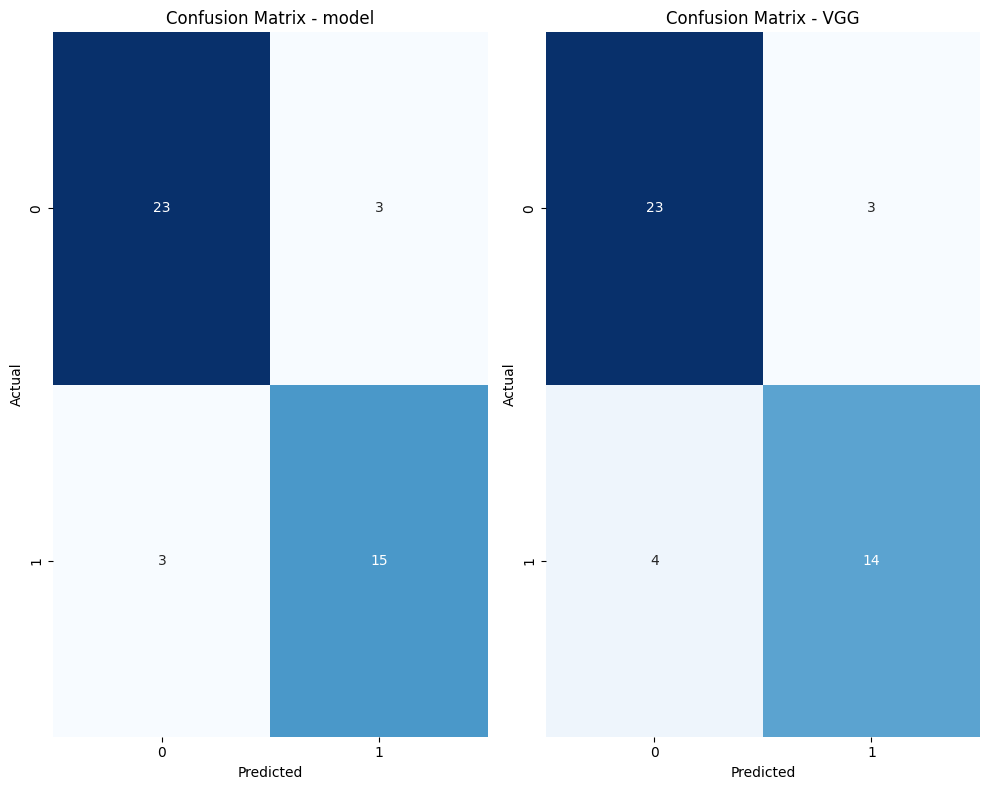

In [88]:
from sklearn.metrics import confusion_matrix

# confusion matrix builder
def plot_confusion_matrix(model_name, y_true, y_pred, ax):
    # model_pred_labels = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, ax = ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


# show the confusion matrix
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8))

plot_confusion_matrix('model', y_test_labels, model_labels, ax[0])
plot_confusion_matrix('VGG', y_test_labels, vgg_labels, ax[1])

plt.tight_layout()
plt.show()

In [89]:
# fetch 10 samples
sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# dictionary
data_dict = {
    'y_true': y_test_labels[sample_indices],
    'model_prediction': model_labels[sample_indices],
    'vgg_prediction': vgg_labels[sample_indices]
}

# put in dataframe
labels_df = pd.DataFrame(data_dict)

# display the dataframe
labels_df

,y_true,model_prediction,vgg_prediction
0,0,0,0
1,1,1,1
2,0,0,1
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,1,0,0
8,0,0,0
9,1,1,0
